# CS446/519 - Class Session 20 - Partial correlation network

In this class session we will continue with analyzing the bladder cancer gene expression dataset.  We'll restrict our attention to a small set of 164 genes that are very highly expressed in cancer (just to keep the analysis simple).  We'll construct a simple "partial correlation network" from the data.

Read the tab-deliminted text file of gene expression measurements (rows correspond to genes, columns correspond to bladder tumor samples). (use `read.table` with `row.names=1`). As always, sanity check that the file that you loaded has the expected dimensions (4,473 x 414)

In [77]:
gene_matrix_for_network <- read.table("shared/bladder_cancer_genes_tcga.txt",
                                     sep="\t",
                                     header=TRUE,
                                     row.names=1,
                                     stringsAsFactors=FALSE)
dim(gene_matrix_for_network)

[1] 4473  414

Filter the matrix to include only rows for which the column-wise median is > 12; matrix should now be 164 x 414; this is not strictly necessary but will help prevent us from over-burderning the EC2 instance and it will enable us to easily compute the partial correlation matrix using the inverse of the covariance matrix.

In [78]:
gene_matrix_filt <- gene_matrix_for_network[apply(gene_matrix_for_network, 1, median) > 12, ]
N <- nrow(gene_matrix_filt)
dim(gene_matrix_filt)

[1] 164 414

Compute the 164 x 164 matrix of gene-gene Pearson correlation coefficients, using `cor` (don't forget that `cor` computes correlations between columns of its matrix argument, so you will have to transpose the data matrix using the `t` function before passing it to `cor`). 

In [79]:
matrix_cor <- cor(t(gene_matrix_filt))
dim(matrix_cor)

[1] 164 164

load the "corpcor" library which has the `cor2pcor` function that we want; it computes the partial correlation matrix (note: if N > M, `cor2pcor` will not work and we need to use `pcor.shrink` based on shrinkage estimation)

In [87]:
library(corpcor)
matrix_pcor <- cor2pcor(matrix_cor)

plot the histograms of the correlation coefficients (upper triangle only) and the partial correlation coefficients, on the same plot using alpha blending (refer to class session 17 exercise)

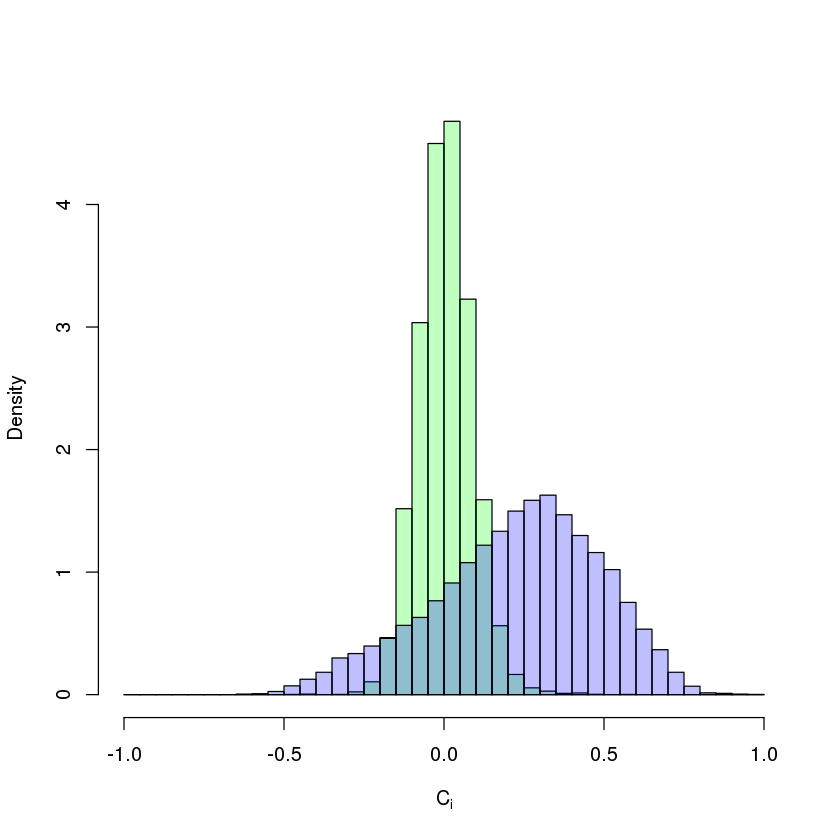

In [88]:
nbreaks <- 40
breaks <- ((0:nbreaks)-(nbreaks/2))/(nbreaks/2)
hist_cor <- hist(matrix_cor[upper.tri(matrix_cor)], breaks=breaks, plot=FALSE)
hist_pcor <- hist(matrix_pcor[upper.tri(matrix_pcor)], breaks=breaks, plot=FALSE)
plotvals <- 0.5*(breaks[1:nbreaks] + breaks[2:(nbreaks+1)])
plot(hist_pcor, col=rgb(0,1,0,1/4), xlab=expression(C[i]), main="", freq=FALSE)
plot(hist_cor, col=rgb(0,0,1,1/4), add=TRUE, freq=FALSE)
legend(0.3, 8, legend=c("cor","pcor"), fill=c(rgb(0,0,1,1/4),rgb(0,1,0,1/4)))

Fisher transform the partial correlation matrix

In [89]:
matrix_z <- 0.5*log((1+matrix_pcor)/(1-matrix_pcor))

Compute a p-value for each gene pair (upper triangle only), using the fact that sqrt(M-N-5) times the fisher Z sore should be approximately univariate normal (with zero mean) under the null hypothesis that a given gene pair's measurements (conditioned on the measurements for all the other 162 genes) are independent. (use `sqrt`, `upper.tri`, `abs`, and `pnorm`)

In [96]:
pvalues <- 2*pnorm(-abs(matrix_z[upper.tri(matrix_z)])*sqrt(M-N-5))

How many gene pairs have a P value less than 0.01? (use `which` and `length`)

In [98]:
length(which(pvalues < 0.01))

[1] 706

What are the sizes of the components in the undirected graph whose edges have `P < 0.01` in the statistical test that you did?  You will need to use `arrayInd`, `cbind`, `graph_from_data_frame`, and `components` (last two of those functions are old friends from `igraph`). As always, print a summary about your graph.

In [126]:
library(igraph)
inds_tri <- which(upper.tri(matrix_z))
inds_sig <- which(pvalues < 0.01)
graph_edge_list <- cbind(arrayInd(inds_tri[inds_sig], 
                 .dim=c(N,N)))
pcor_graph <- graph_from_data_frame(graph_edge_list, directed=FALSE)
summary(pcor_graph)
components(pcor_graph)$csize

IGRAPH UN-- 164 706 -- 
+ attr: name (v/c)


[1] 164

Plot the graph in igraph (make sure you first set the plot options using
`igraph_options(vertex.size=1, vertex.label=NA, edge.width=0.3)`)

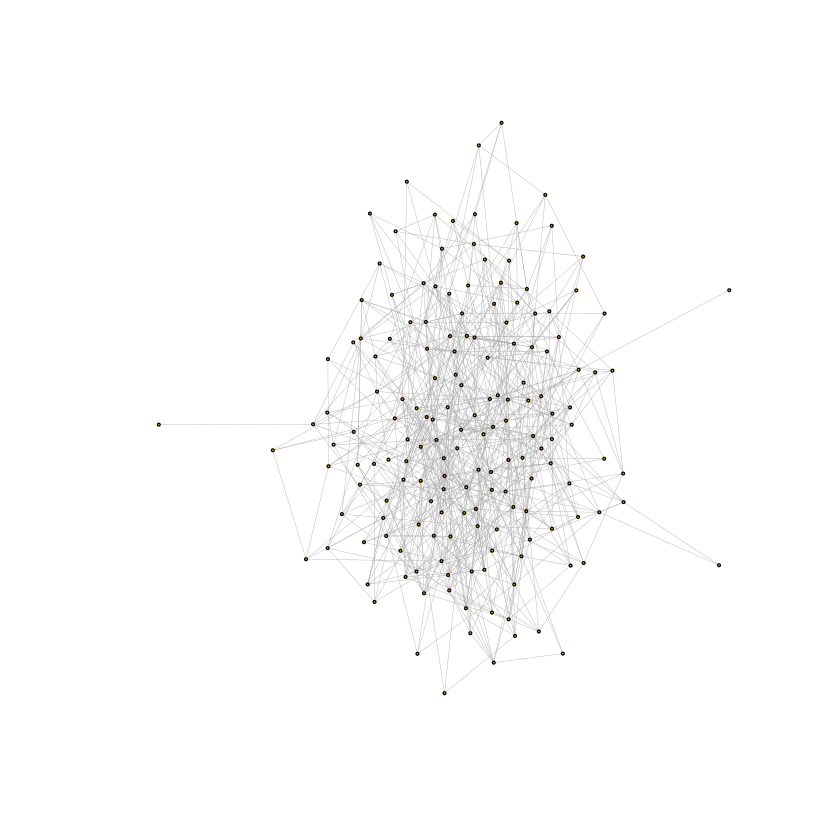

In [129]:
igraph_options(vertex.size=1, vertex.label=NA, edge.width=0.3, margin=-5)
plot(pcor_graph)

Plot the graph degree distribution on log-log scale

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"2 y values <= 0 omitted from logarithmic plot"

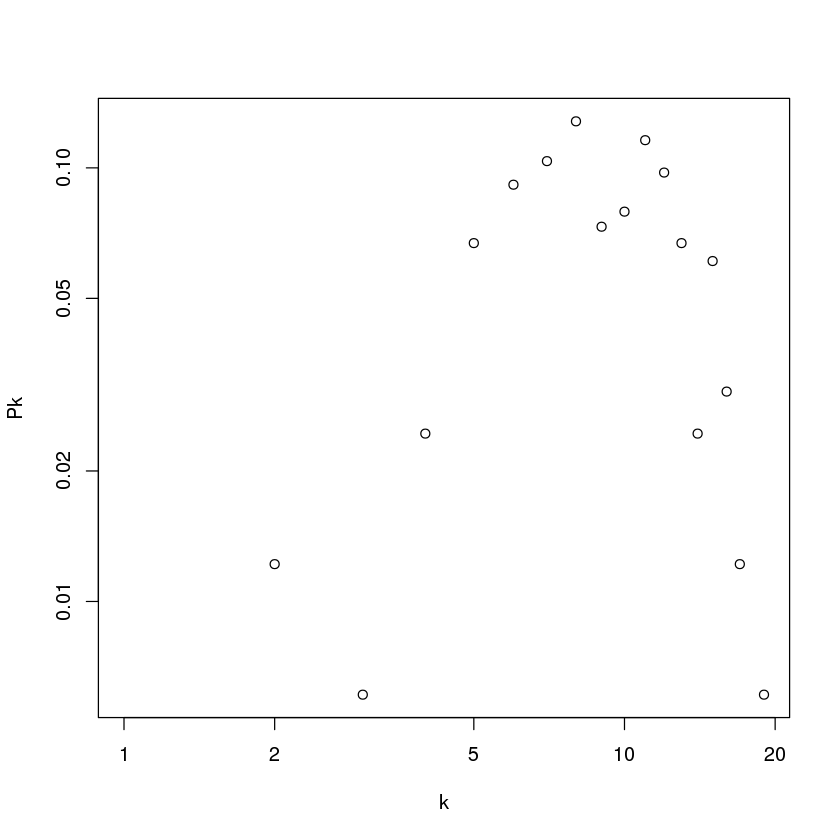

In [124]:
plot(degree.distribution(pcor_graph), log="xy", xlab="k", ylab="Pk")